## EE542 Lab 10: Exploring patterns of tumor malignancy with respect to miRNA expression quantification data using machine learning models

#### Ali Afzal, Spencer McDonough, Zane Pazooki

The miRNA sequence data was obtained from the Genomics Data Commons (GDC) Portal. Our selection was as follows: 

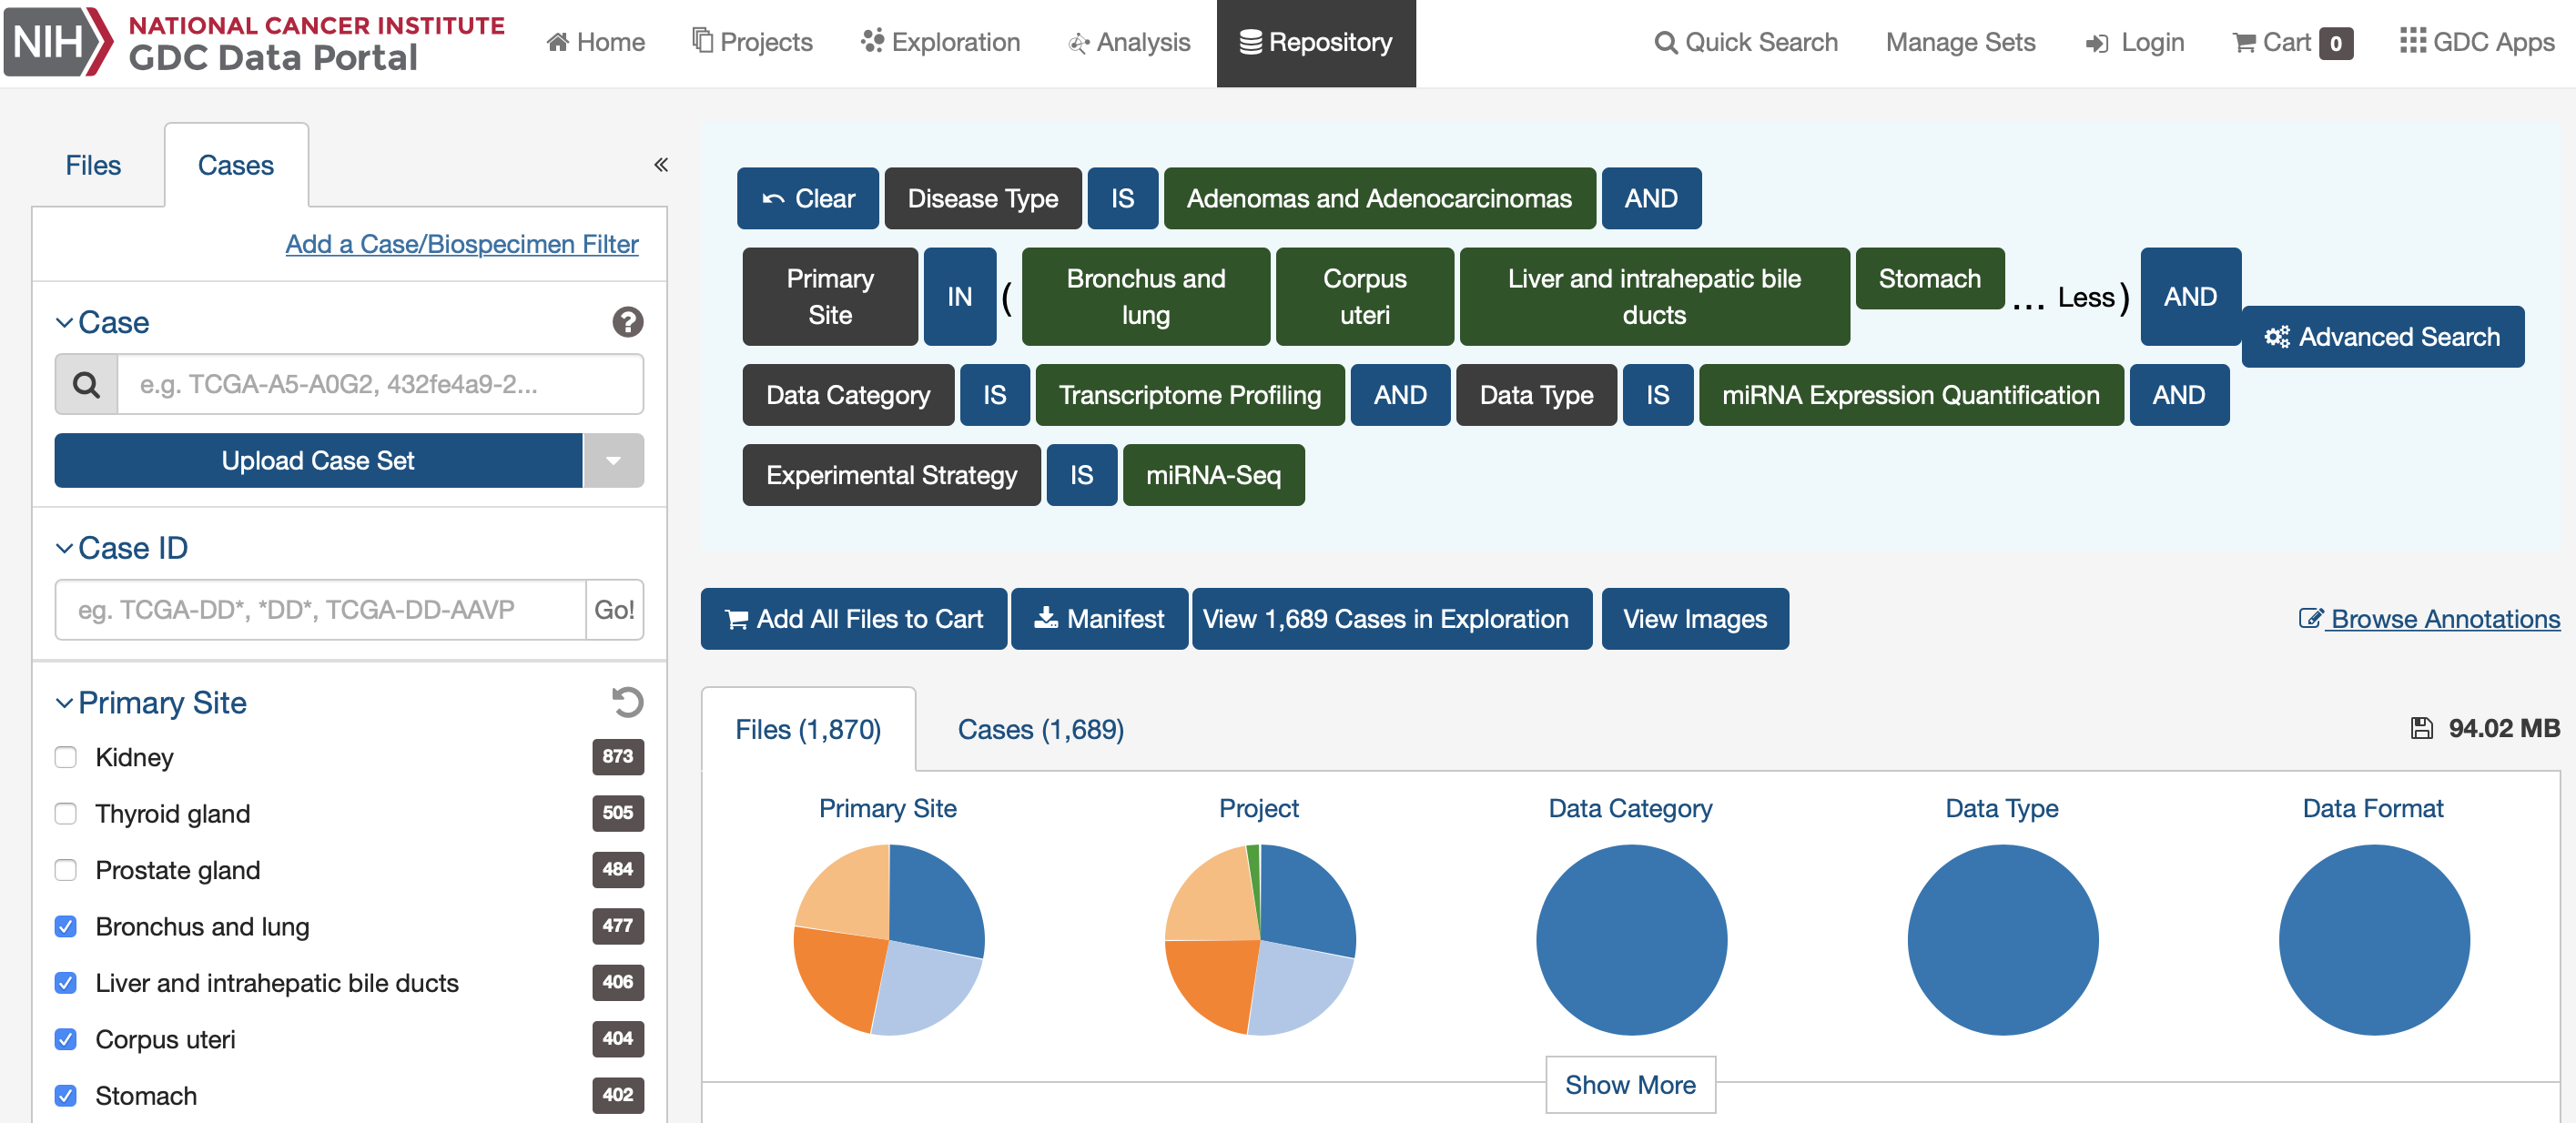

#### The .csv files for each were downloaded using the gdc client and preprocessed:


In [45]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

df_stomach = pd.read_csv(os.getcwd() + "/stomach.csv")
df_lung = pd.read_csv(os.getcwd() + "/lung.csv")
df_liver = pd.read_csv(os.getcwd() + "/liver.csv")
df_uterus = pd.read_csv(os.getcwd() + "/uterus.csv")

frames = [df_stomach, df_lung, df_liver, df_uterus]

df = pd.concat(frames, ignore_index=True)

df.dropna(axis=0) # drop rows with at least one NA
df.dropna(axis=1) # drop cols with at least one NA

df.loc[df['label'] == 1, 'label'] = 'cancerous'
df.loc[df['label'] == 0, 'label'] = 'benign'

df['y'] = df['Primary Site'] + ' Adenomas ' + df['label']
#y_data = df[['Primary Site', 'label']].copy()

y_data = df.pop('y')

df.pop('label')
df.pop('Primary Site')
df.pop('file_id')
df.pop('Unnamed: 0')
X_data = df.values.astype('float64', copy=False)

# Using numerical output is preferred but not needed in this lab. 
# Thw two methods we used are included below. 

# y_data = pd.get_dummies(y_data, drop_first=True)

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(categorical_features=[0])
# ohe.fit_transform(y_data).toarray()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

Although we could have used a single pipeline and grid search, we have broken it down for demonstration purposes.

First the optimal k is obtained for k neighbors classifier

In [46]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(metric='minkowski'))

# sorted(pipe_knn.get_params().keys()) used to get the parameters for grid search

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kneighborsclassifier__n_neighbors': [3,4,5,6,7], 'kneighborsclassifier__p':[1,2]}],
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8586707410236822
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__p': 1}


We can see that 5 nearest neighbors and the p=1 norm gives the best results. 

The Evaluation metrics are visualized below:

k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.71      0.89      0.79        19
  liver cancerous       0.84      0.77      0.81       127
      lung benign       0.75      0.69      0.72        13
   lung cancerous       0.82      0.72      0.77       146
   stomach benign       0.80      0.92      0.86        13
stomach cancerous       0.72      0.73      0.72       127
    uterus benign       0.60      0.75      0.67         4
 uterus cancerous       0.64      0.75      0.69       112

      avg / total       0.76      0.75      0.75       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


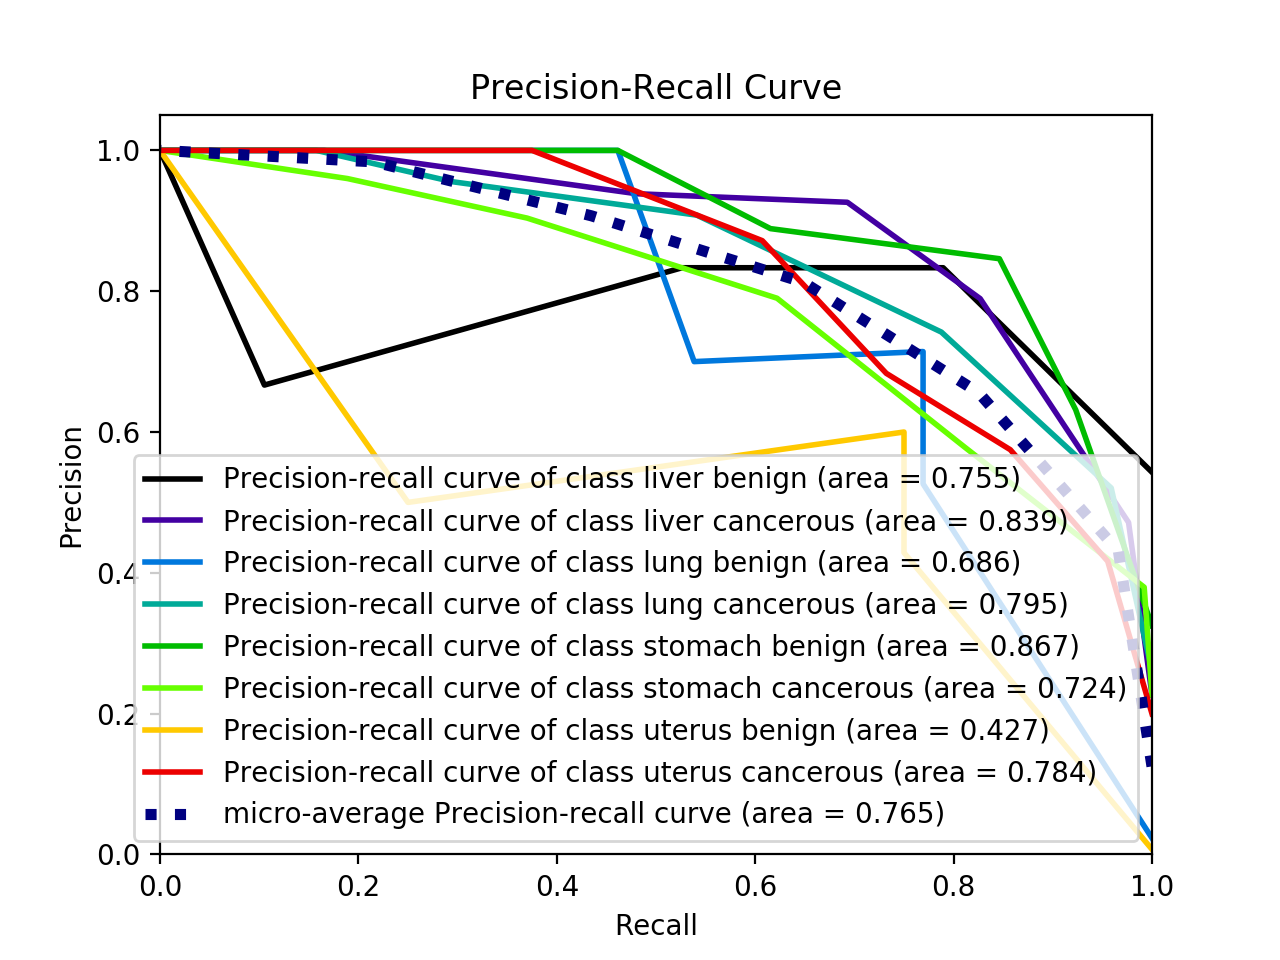

<IPython.core.display.Javascript object>


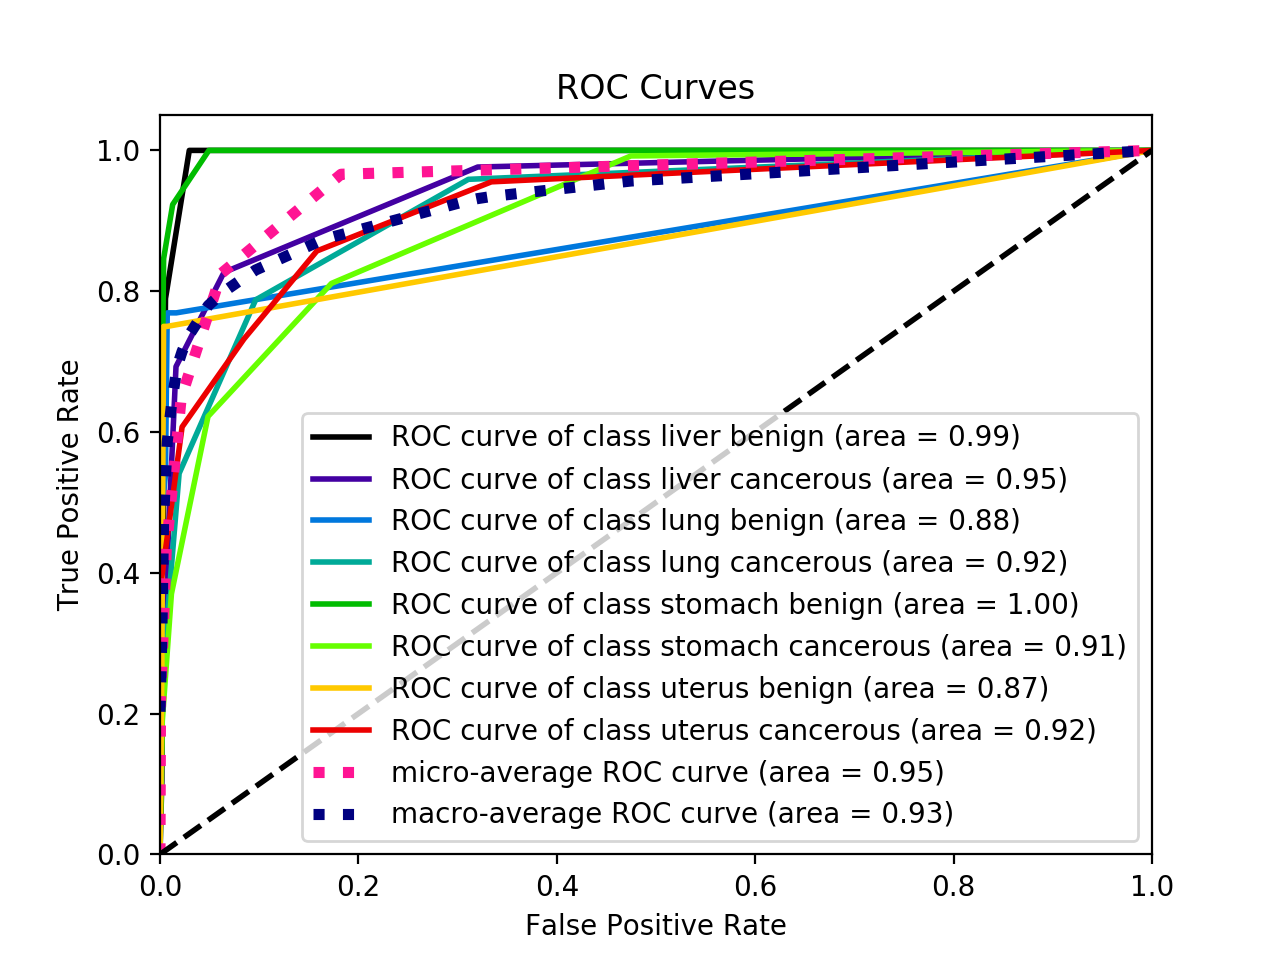

In [22]:
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

from sklearn.metrics import classification_report

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))

import scikitplot as skplt
%matplotlib notebook

skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

We also obtain the cross validation score to ensure we are not overfitting.

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_knn, X=X_train, y=y_train, cv=5, n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.76603774 0.78030303 0.73664122 0.77011494 0.77821012]


#### Feature Selection via Random Forest Classifier

<IPython.core.display.Javascript object>


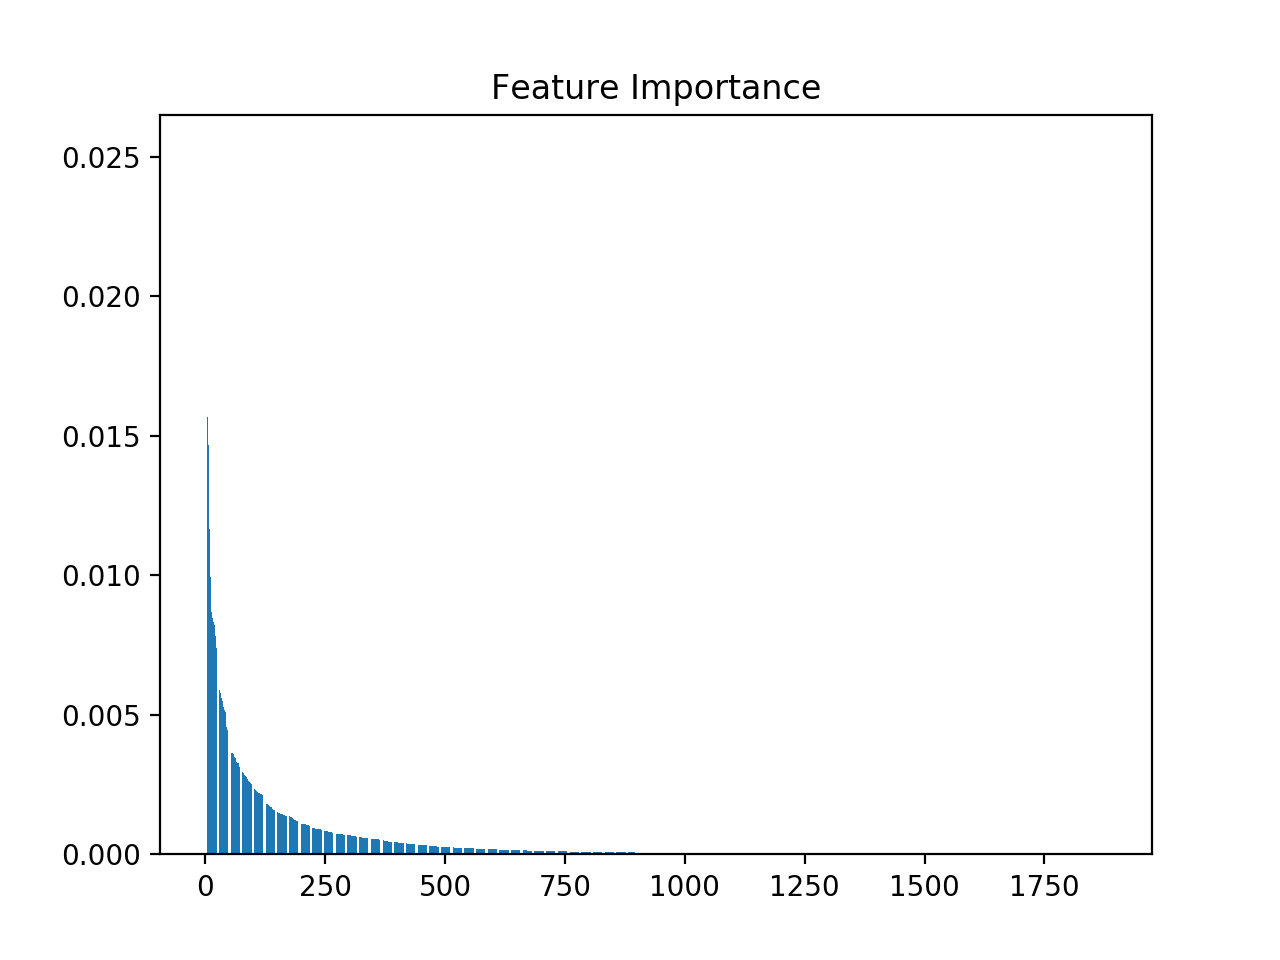

<BarContainer object of 1881 artists>

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
columns = df.columns # original imported csv dataframe

%matplotlib notebook
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')

The 0.001 threshhold seems reasonable, the proteins are listed below:

In [57]:
#for f in range(X_train.shape[1]): # to get the full results 
for f in range(20):
    print("%2d) %-*s %f" % (f + 1, 30, columns[indices[f]], importances[indices[f]]))

 1) hsa-mir-194-2                  0.025219
 2) hsa-mir-194-1                  0.018835
 3) hsa-mir-885                    0.018080
 4) hsa-mir-192                    0.017793
 5) hsa-mir-196b                   0.017455
 6) hsa-mir-215                    0.015681
 7) hsa-mir-205                    0.015238
 8) hsa-mir-122                    0.014672
 9) hsa-mir-10b                    0.012187
10) hsa-mir-200c                   0.011646
11) hsa-mir-141                    0.011381
12) hsa-mir-1295b                  0.009928
13) hsa-mir-9-3                    0.008797
14) hsa-mir-200a                   0.008694
15) hsa-mir-511                    0.008568
16) hsa-mir-429                    0.008481
17) hsa-mir-139                    0.008401
18) hsa-mir-135b                   0.008336
19) hsa-mir-5589                   0.008287
20) hsa-mir-3591                   0.008207


Now, using the threshhold we grid serach for the optimal number of estimators for the forest:

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

pipe_knn = make_pipeline(StandardScaler(),
                         #SelectFromModel(LassoCV(), threshold=0), we tried lasso but forests gave better results
                         SelectFromModel(RandomForestClassifier(), threshold=0.001),
                         KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'))

# sorted(pipe_knn.get_params().keys())

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'selectfrommodel__estimator__n_estimators': [10, 50, 100, 500, 1000]}],
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9541634835752483
{'selectfrommodel__estimator__n_estimators': 50}


As demosntrated above, 50 estimators gives the most accurate results:

k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.90      1.00      0.95        19
  liver cancerous       0.99      0.95      0.97       127
      lung benign       0.85      0.85      0.85        13
   lung cancerous       0.94      0.97      0.96       146
   stomach benign       0.85      0.85      0.85        13
stomach cancerous       0.95      0.97      0.96       127
    uterus benign       1.00      1.00      1.00         4
 uterus cancerous       1.00      0.96      0.98       112

      avg / total       0.96      0.96      0.96       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


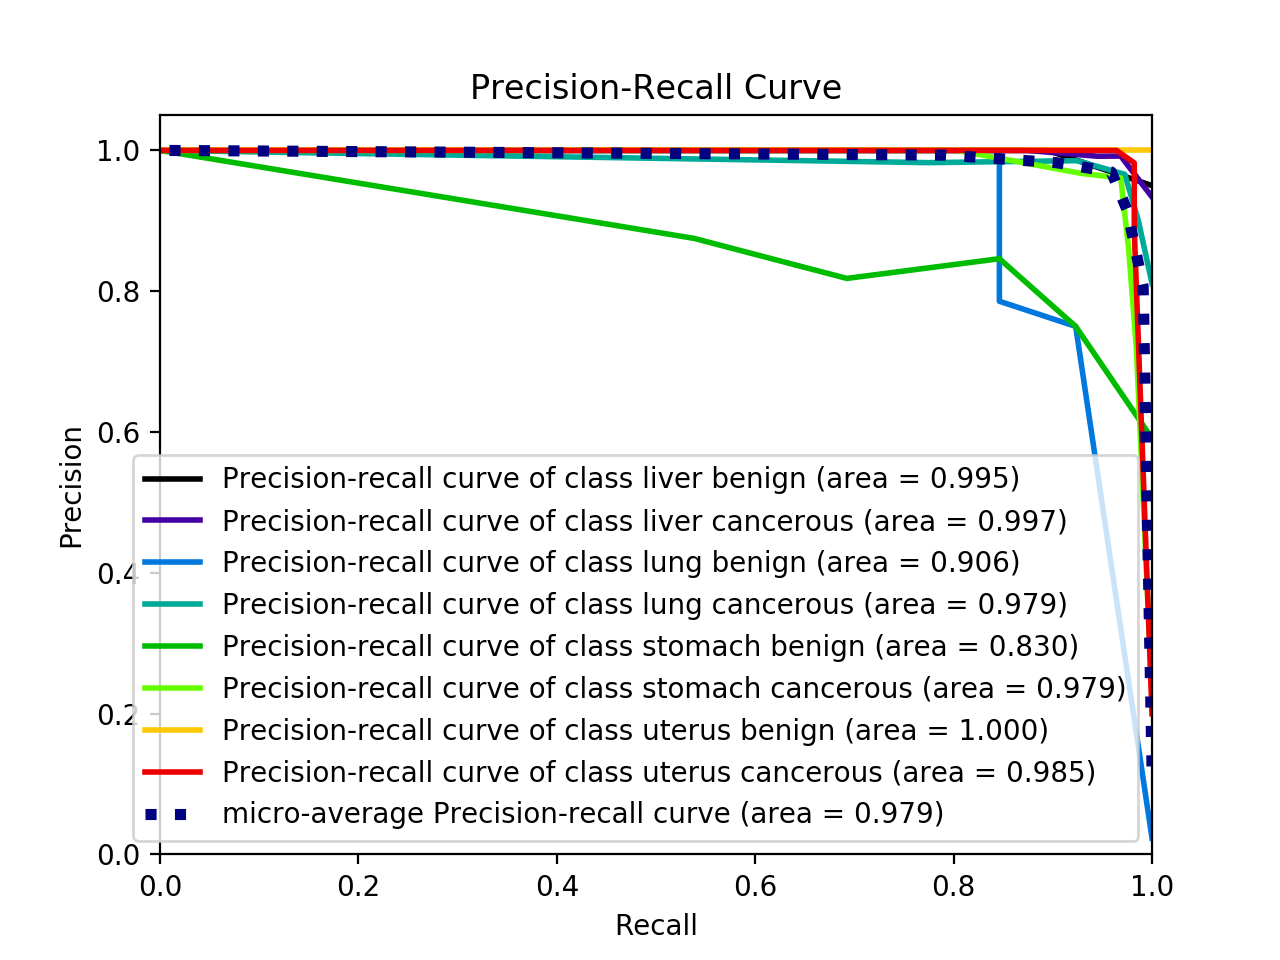

<IPython.core.display.Javascript object>


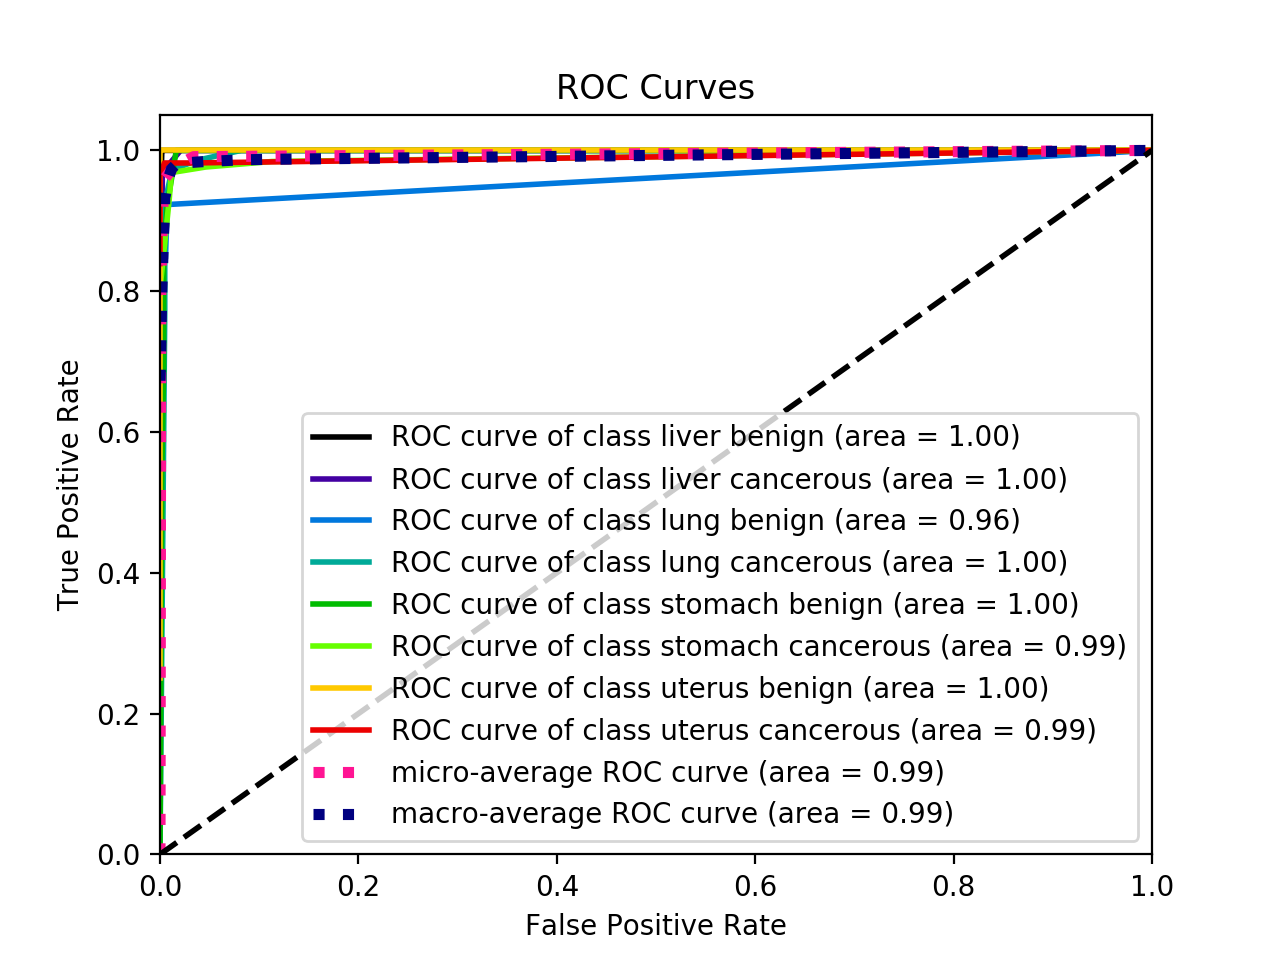

In [29]:
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))

%matplotlib notebook
skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_knn, X=X_train, y=y_train, cv=5, n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.95471698 0.95833333 0.95038168 0.93103448 0.94552529]


### Visualization with different dimension reduction techniques:

<IPython.core.display.Javascript object>


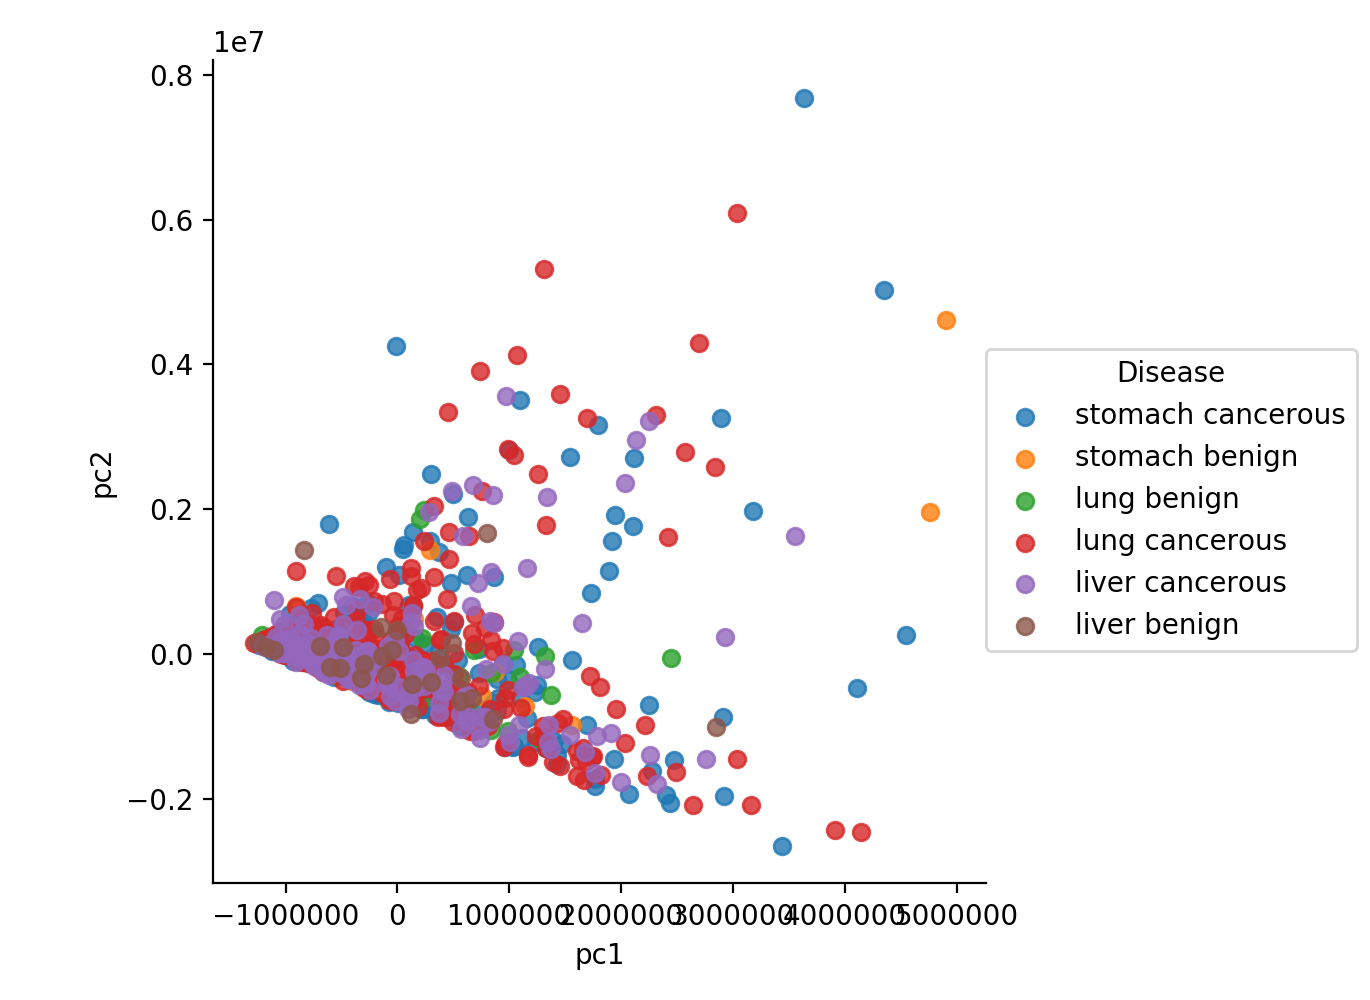

<IPython.core.display.Javascript object>


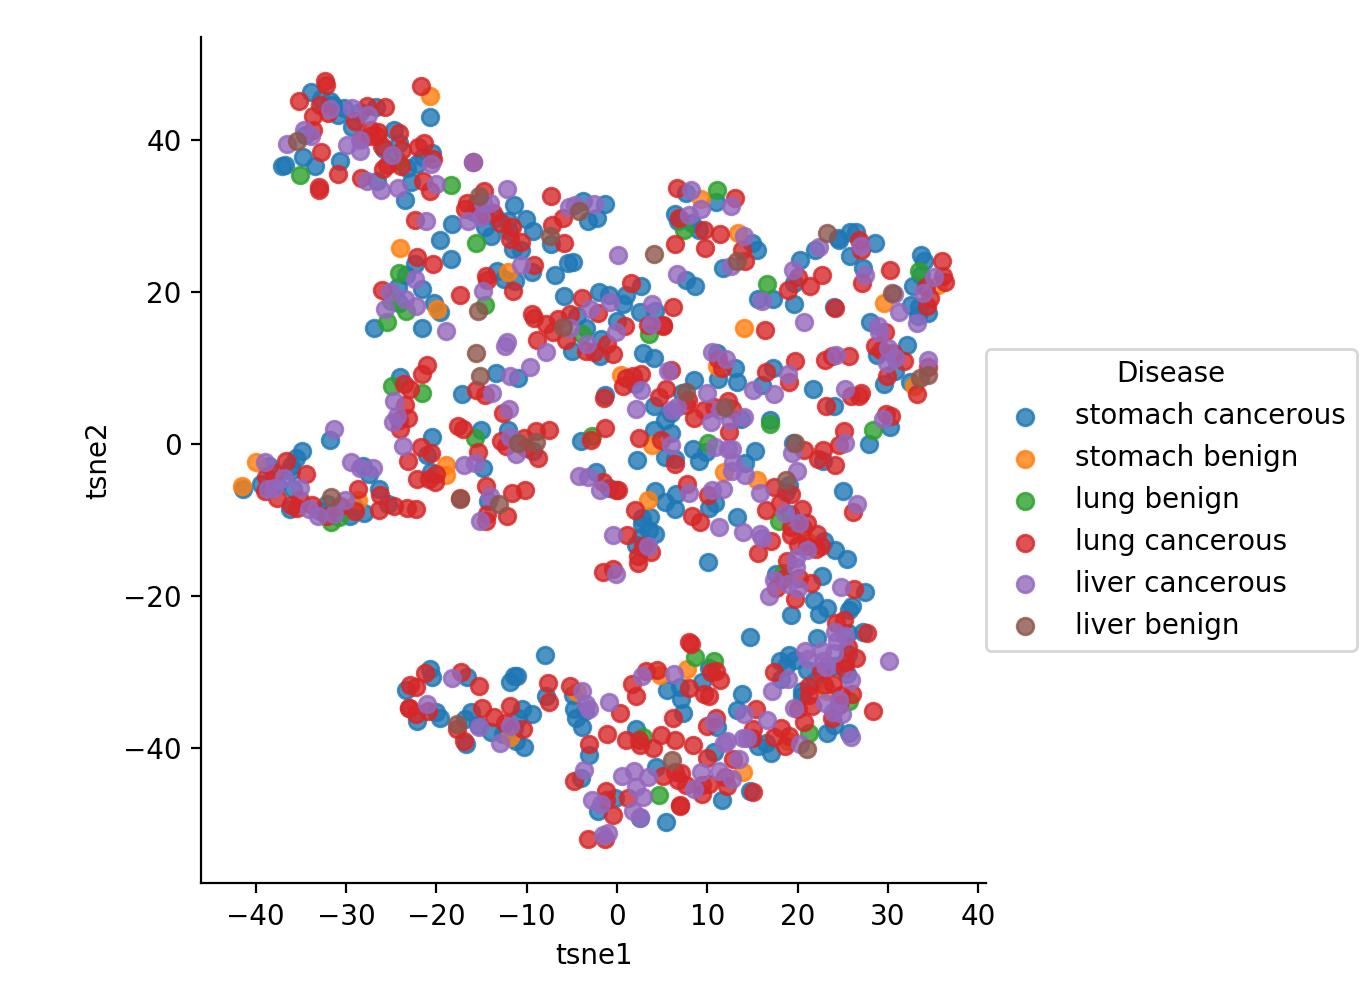

<IPython.core.display.Javascript object>


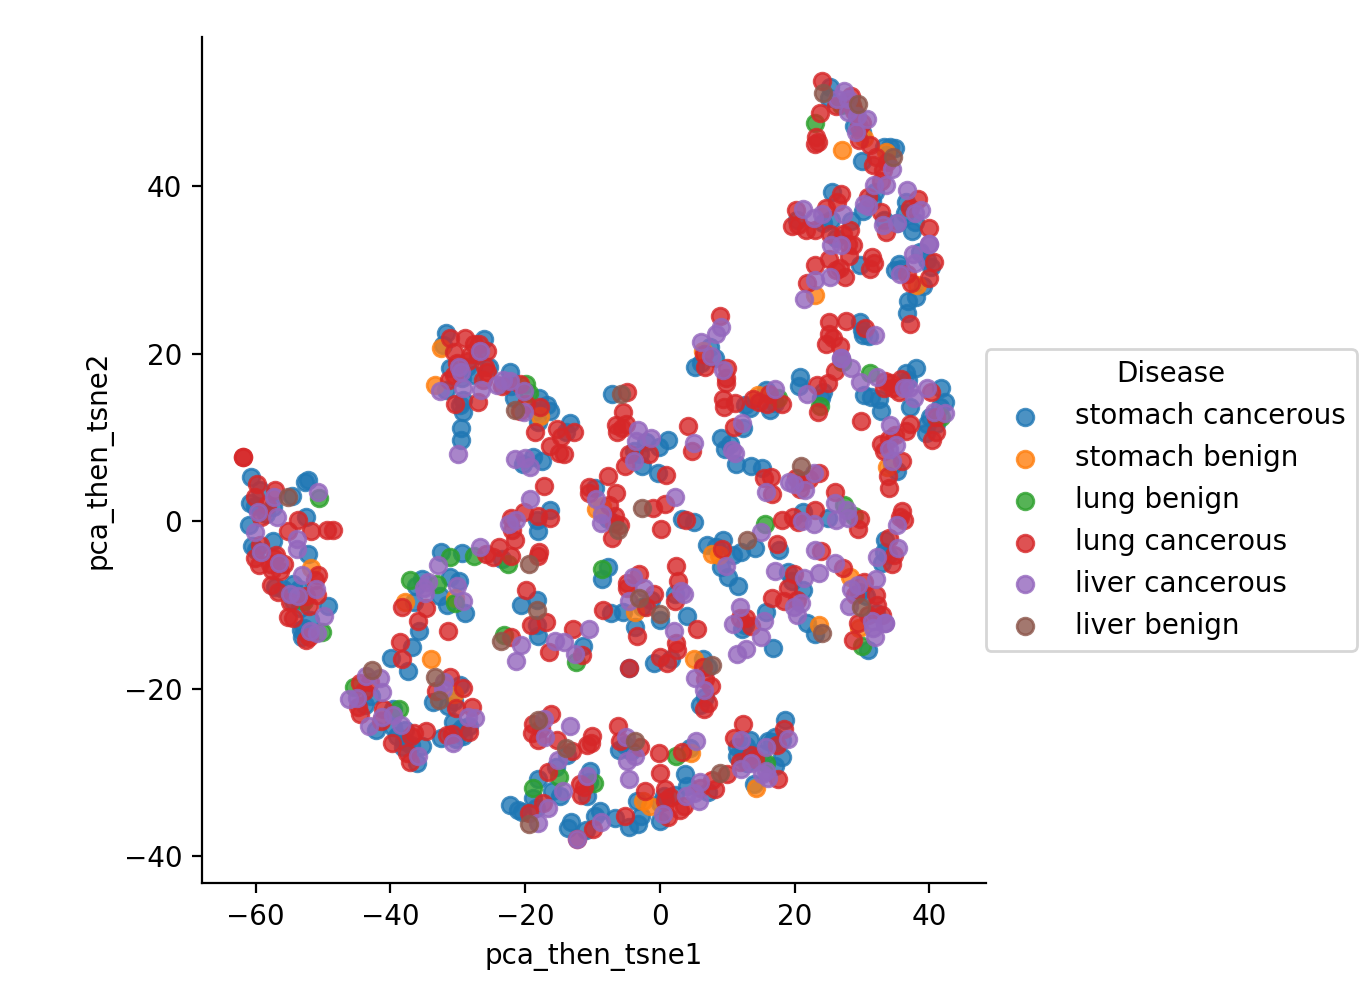

In [29]:
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components = 2).fit_transform(X_train)
tsne = TSNE(learning_rate=200).fit_transform(X_train)
pca_then_tsne = TSNE(learning_rate=200).fit_transform(pca)
mds = MDS(n_components = 2).fit_transform(X_train)
iso = Isomap(n_components = 2).fit_transform(X_train)

df_pca = pd.DataFrame(data = pca , columns = ['pc1', 'pc2'])
df_pca['Disease'] = y_train
sns.lmplot(x='pc1', y='pc2', data=df_pca, fit_reg=False, hue='Disease', legend=True)

df_tsne = pd.DataFrame(data = tsne , columns = ['tsne1', 'tsne2'])
df_tsne['Disease'] = y_train
sns.lmplot(x='tsne1', y='tsne2', data=df_tsne, fit_reg=False, hue='Disease', legend=True)

df_pca_then_tsne = pd.DataFrame(data = pca_then_tsne , columns = ['pca_then_tsne1', 'pca_then_tsne2'])
df_pca_then_tsne['Disease'] = y_train
sns.lmplot(x='pca_then_tsne1', y='pca_then_tsne2', data=df_pca_then_tsne, fit_reg=False, hue='Disease', legend=True)

<IPython.core.display.Javascript object>


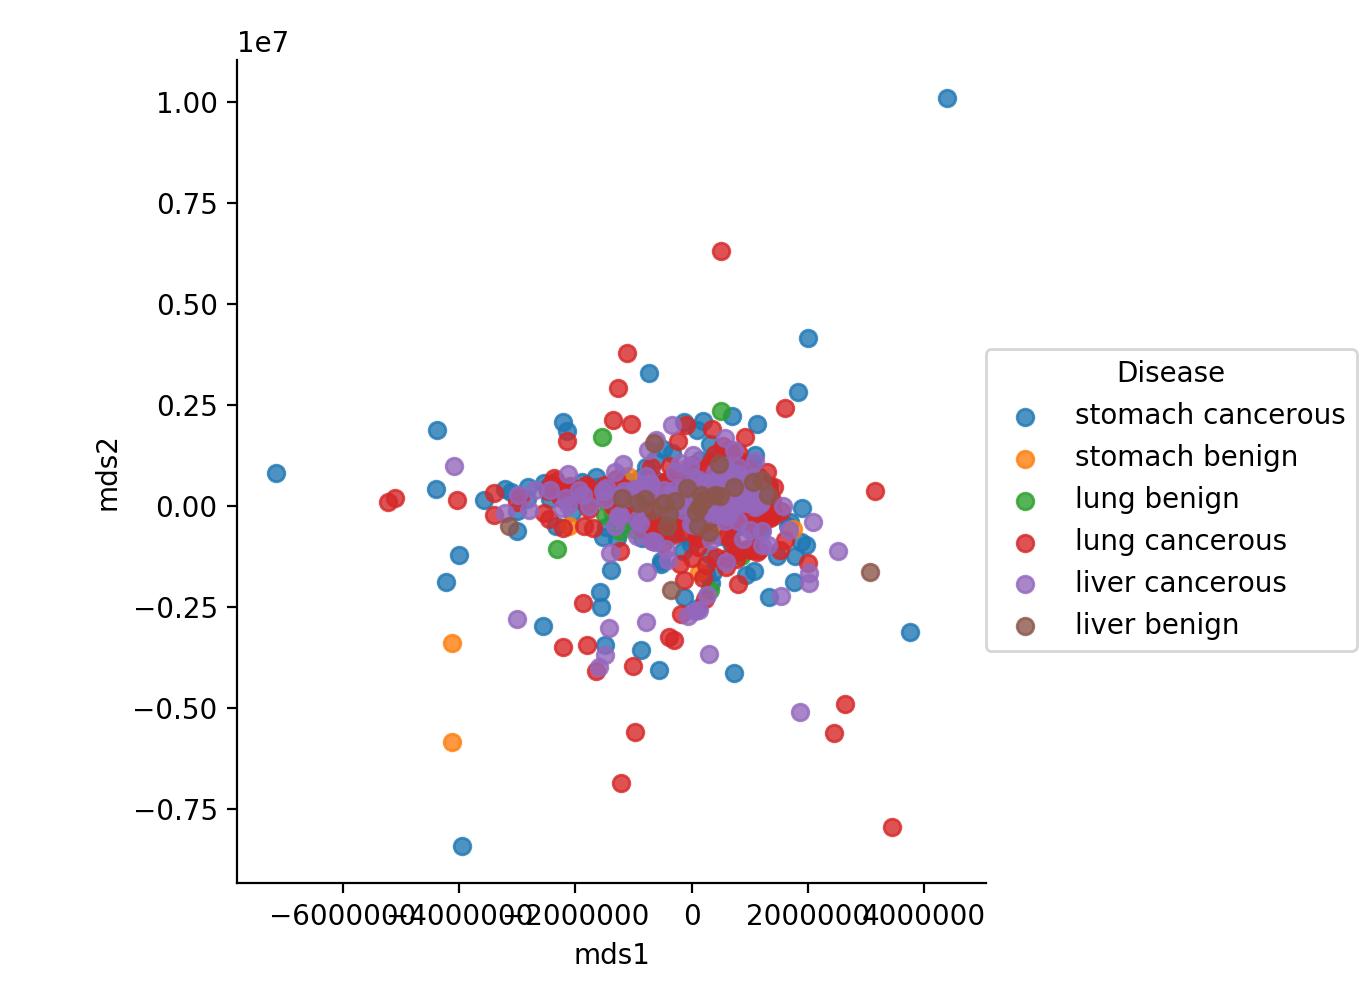

<IPython.core.display.Javascript object>


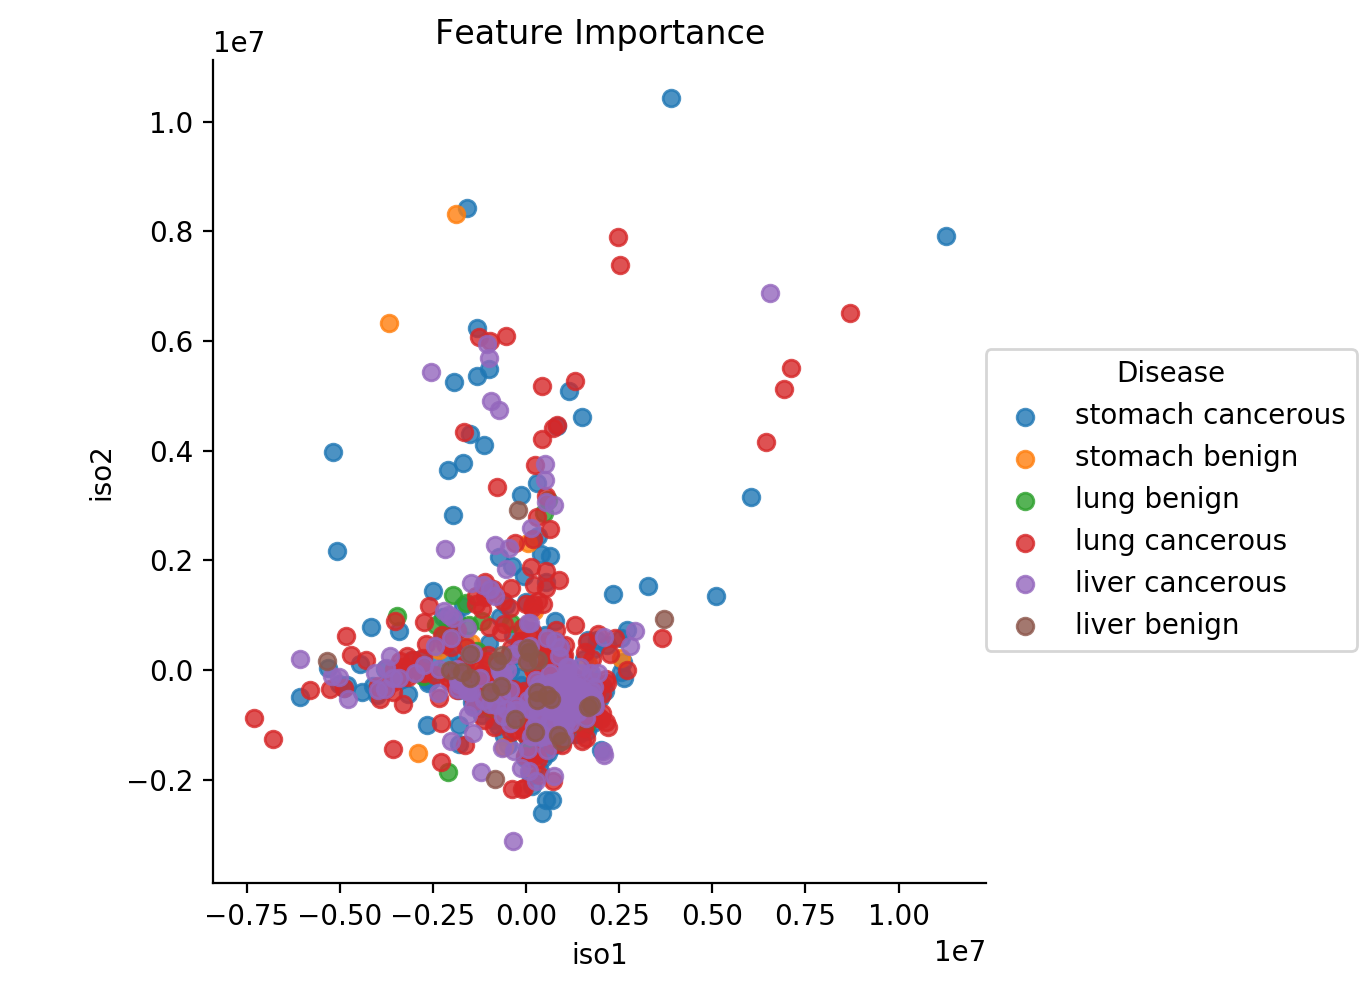

In [30]:
df_mds = pd.DataFrame(data = mds , columns = ['mds1', 'mds2'])
df_mds['Disease'] = y_train
sns.lmplot(x='mds1', y='mds2', data=df_mds, fit_reg=False, hue='Disease', legend=True)

df_iso = pd.DataFrame(data = iso , columns = ['iso1', 'iso2'])
df_iso['Disease'] = y_train
sns.lmplot(x='iso1', y='iso2', data=df_iso, fit_reg=False, hue='Disease', legend=True)

Given the plots, dimension reduction is unlikely to imporve results. Therefore, now we grid search for the correct model as well as the number of components.

In [32]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('feature selection', SelectFromModel(RandomForestClassifier(n_estimators=50), threshold=0.001)),
    ('reduce_dim', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'))
])

param_grid = [
    {
        'reduce_dim': [PCA(), Isomap(), TruncatedSVD()],
        'reduce_dim__n_components': [2, 3],
    },
]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.881588999236058
{'reduce_dim': Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0), 'reduce_dim__n_components': 3}


k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.71      0.89      0.79        19
  liver cancerous       0.92      0.89      0.90       127
      lung benign       0.62      0.77      0.69        13
   lung cancerous       0.90      0.87      0.89       146
   stomach benign       0.56      0.38      0.45        13
stomach cancerous       0.87      0.92      0.89       127
    uterus benign       0.00      0.00      0.00         4
 uterus cancerous       0.96      0.96      0.96       112

      avg / total       0.88      0.89      0.88       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


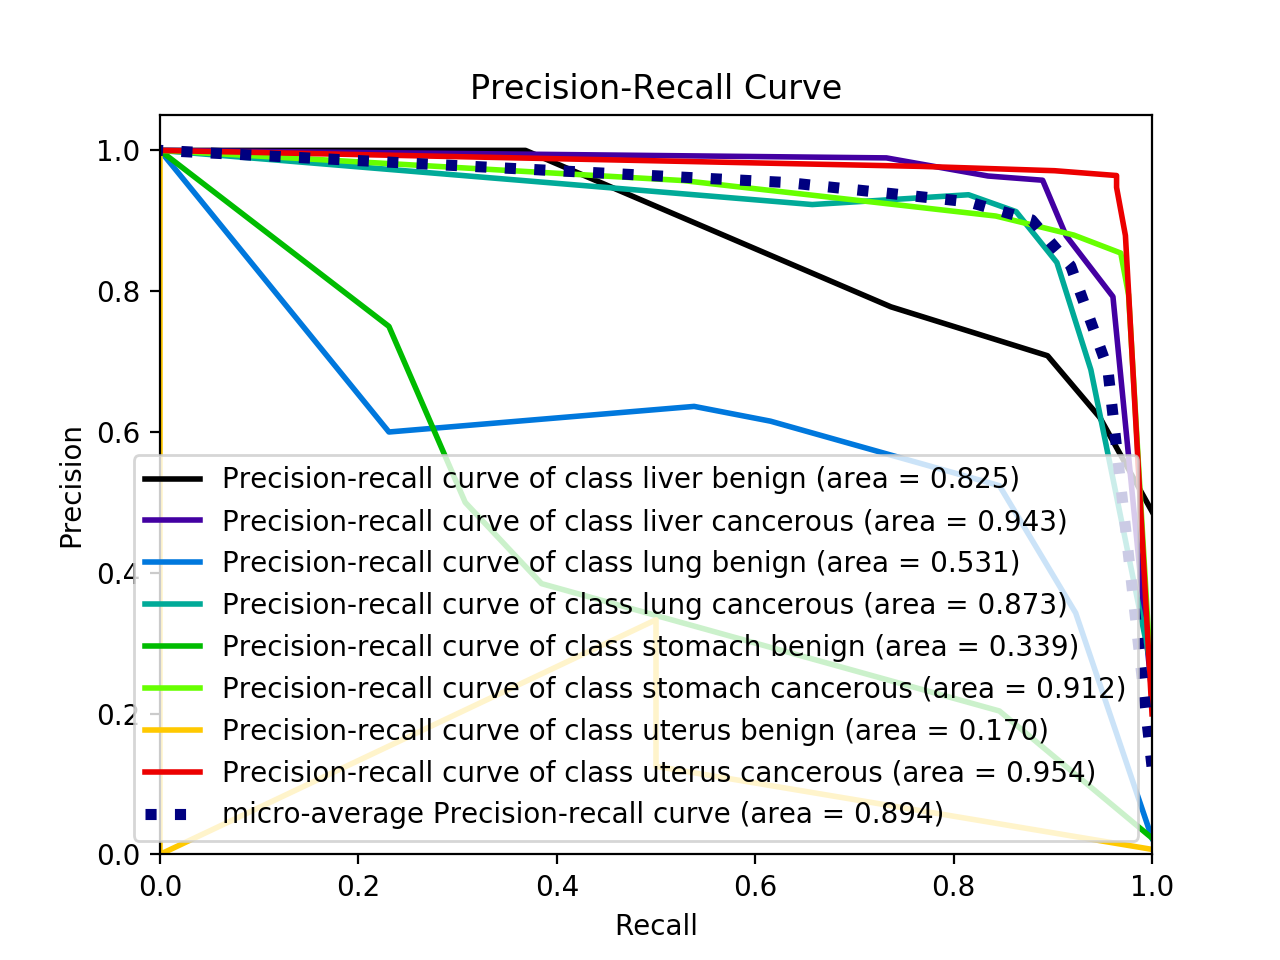

<IPython.core.display.Javascript object>


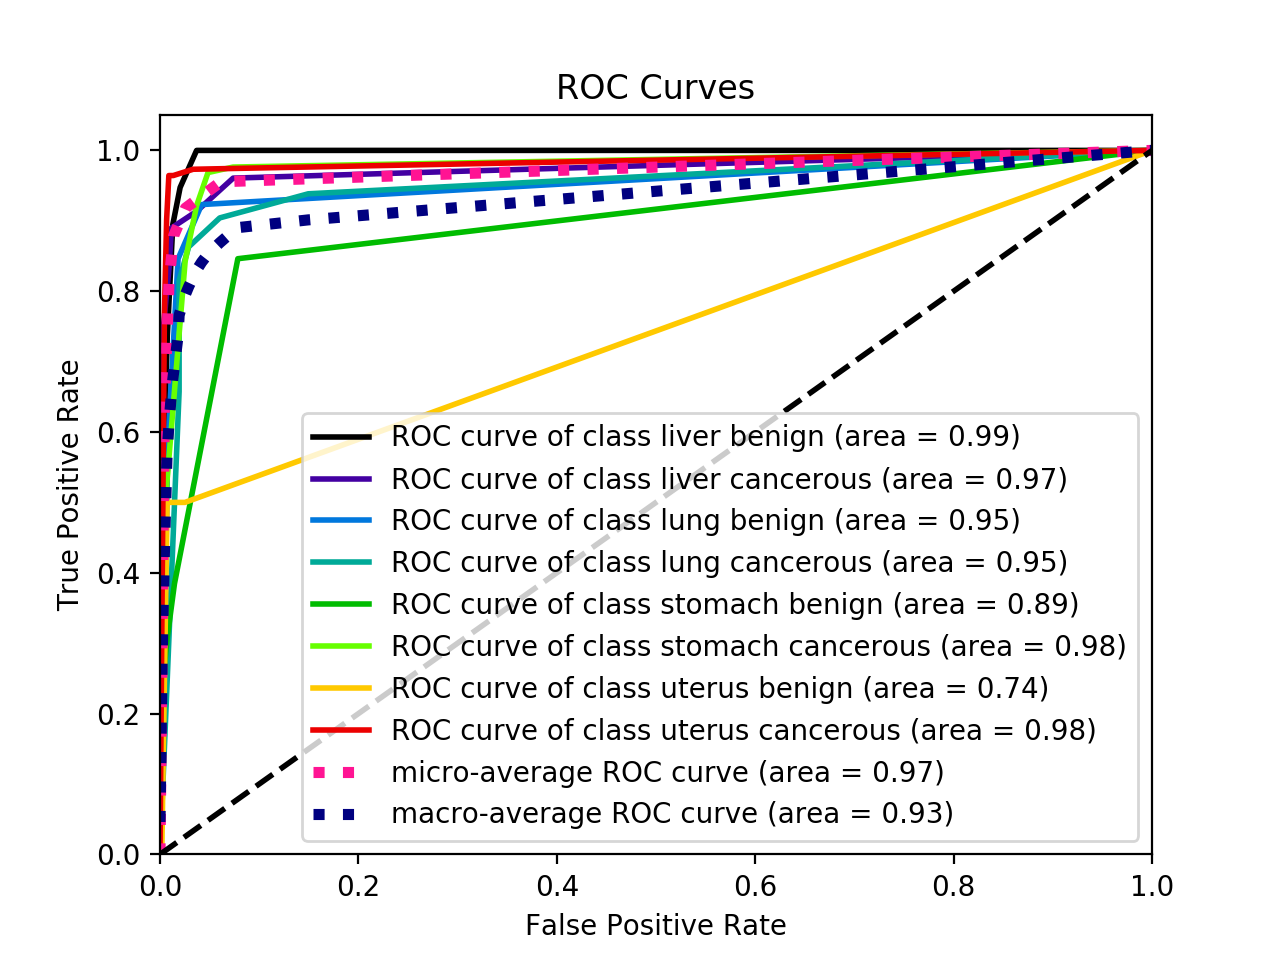

In [33]:
pipe_knn = make_pipeline(StandardScaler(),
                         SelectFromModel(RandomForestClassifier(n_estimators=1000), threshold=0.001),
                         Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=1,
                                n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0),
                         KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'))

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))
%matplotlib notebook
skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

As shown above, dimension reduction rechniques are not improving the evaluation metrics. The reason is the extreme sparsity of the data in the dataset. We now show a cluster map of the data to confirm our conjecture and then a 3d principal components plot to test kernel pca. 

<IPython.core.display.Javascript object>


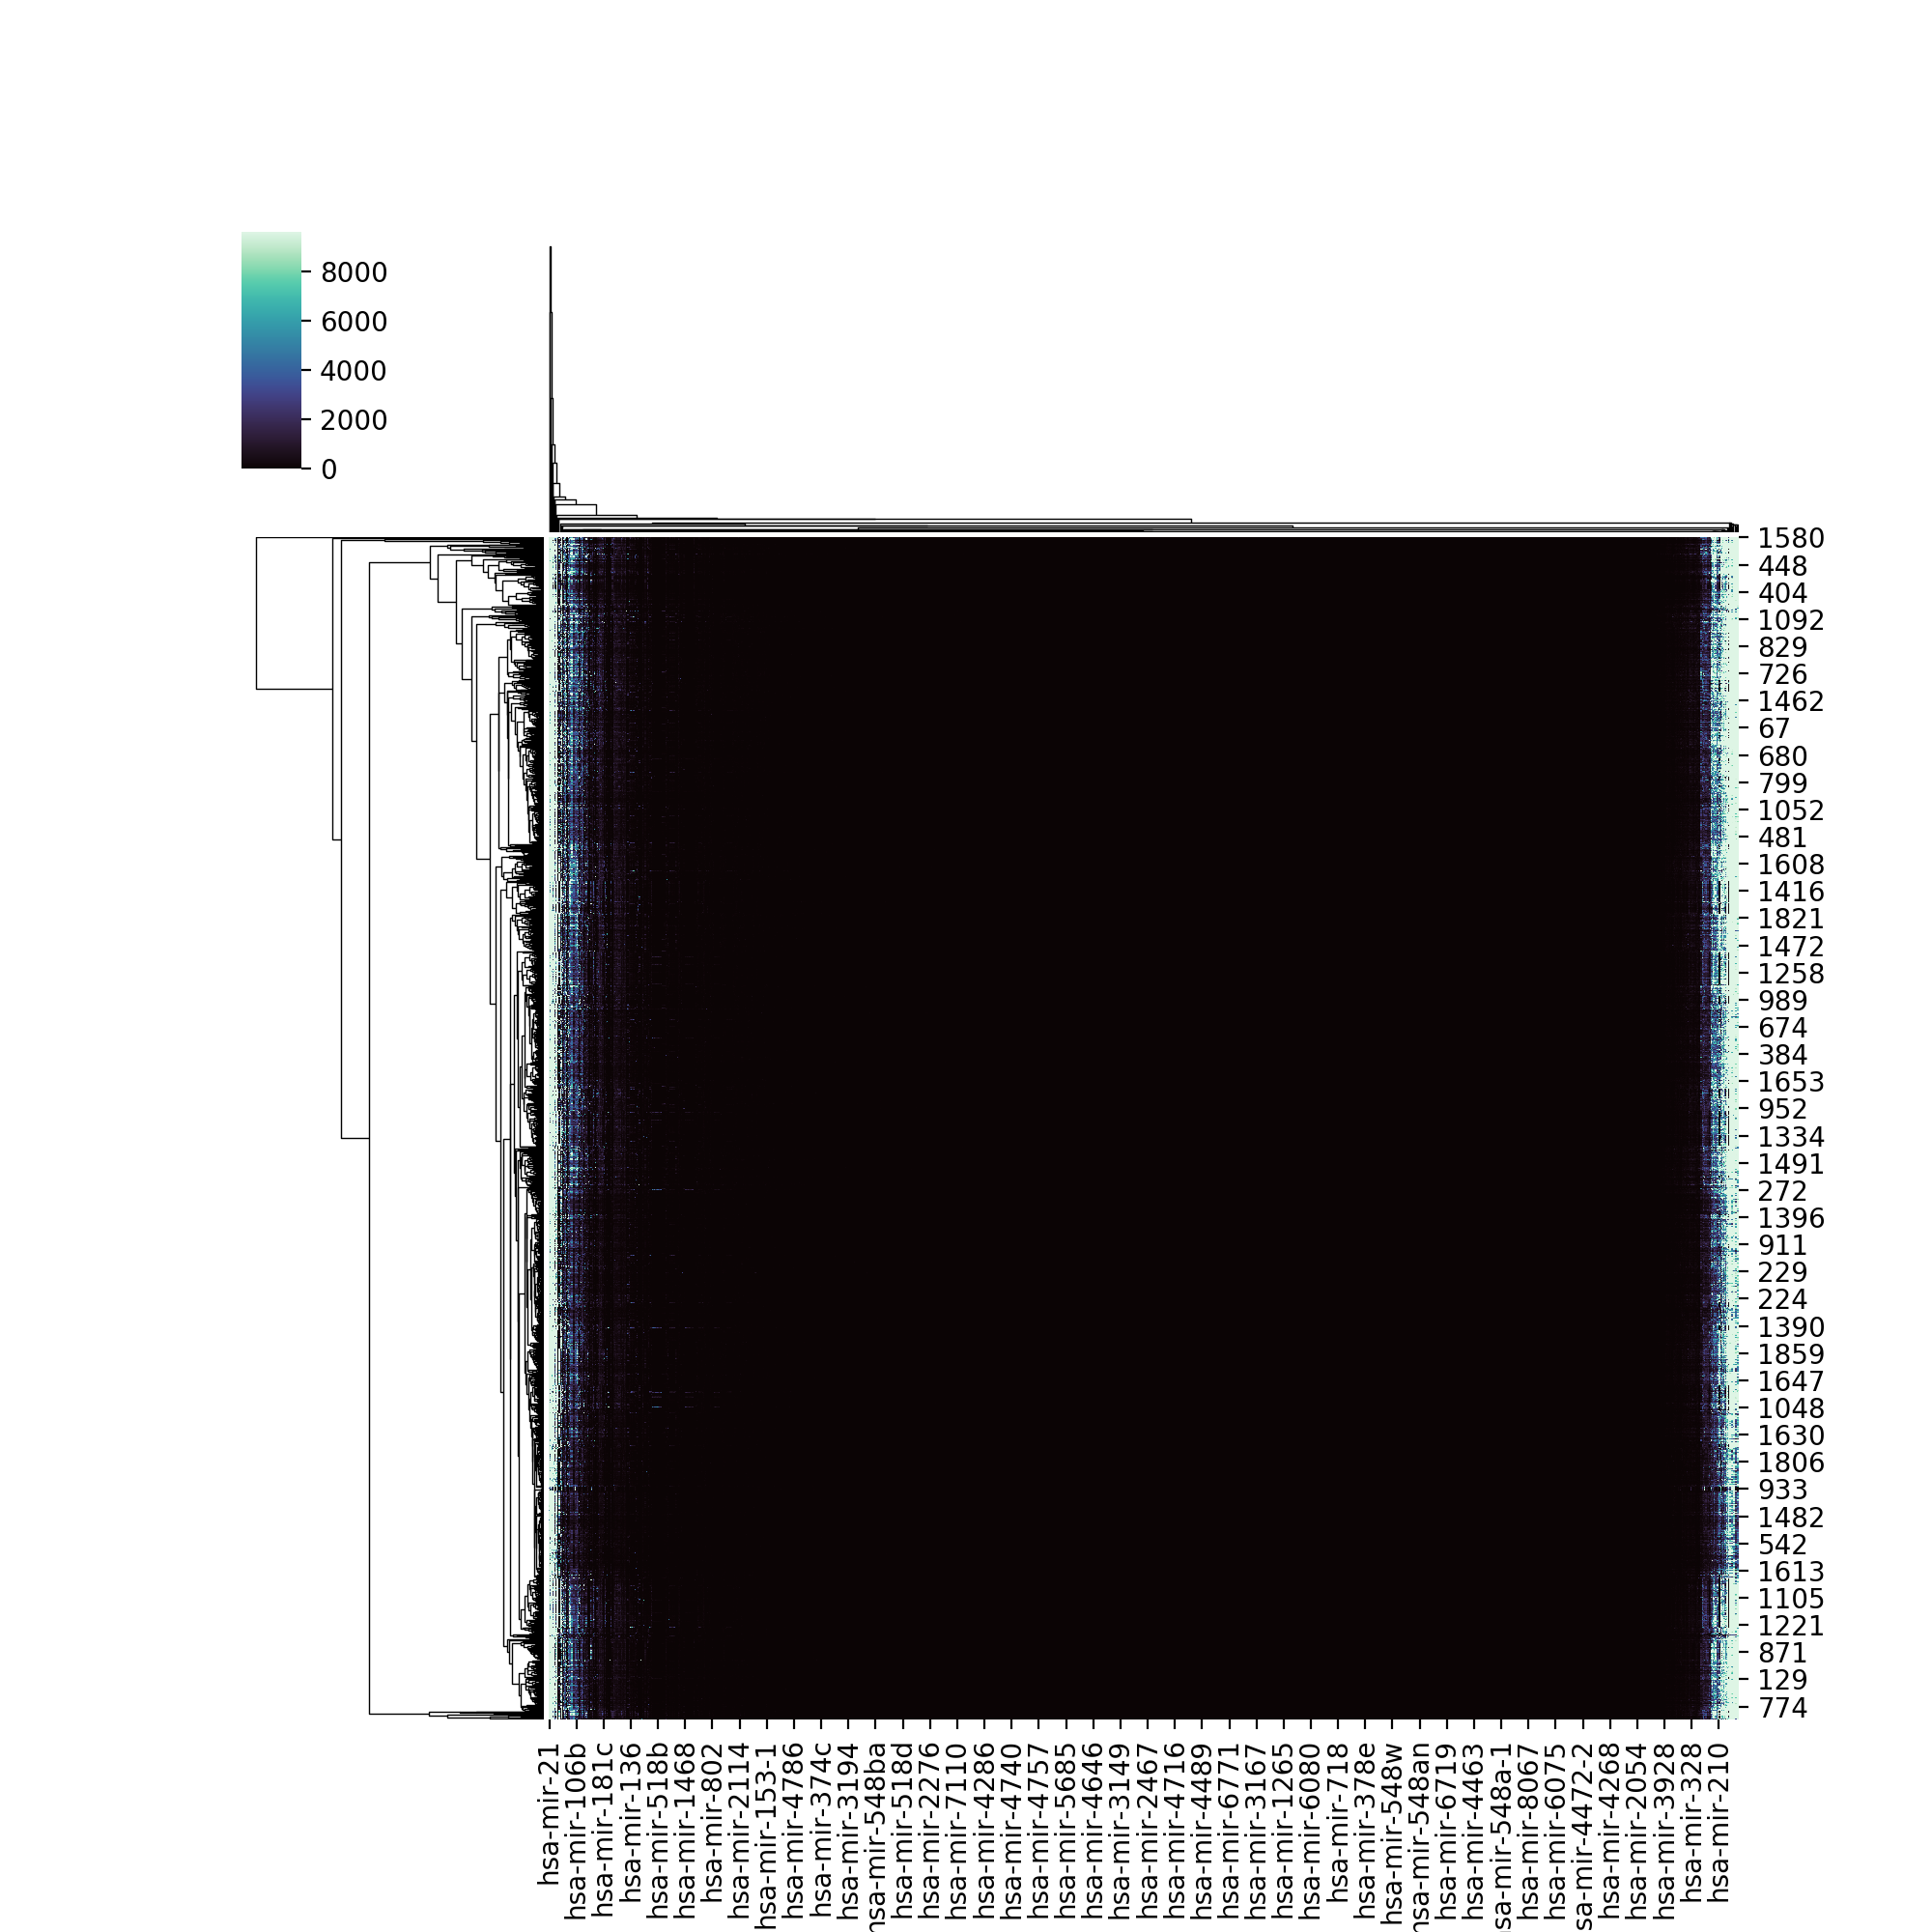

In [41]:
g = sns.clustermap(df, cmap="mako", robust=True) # ignoring outliers

<IPython.core.display.Javascript object>


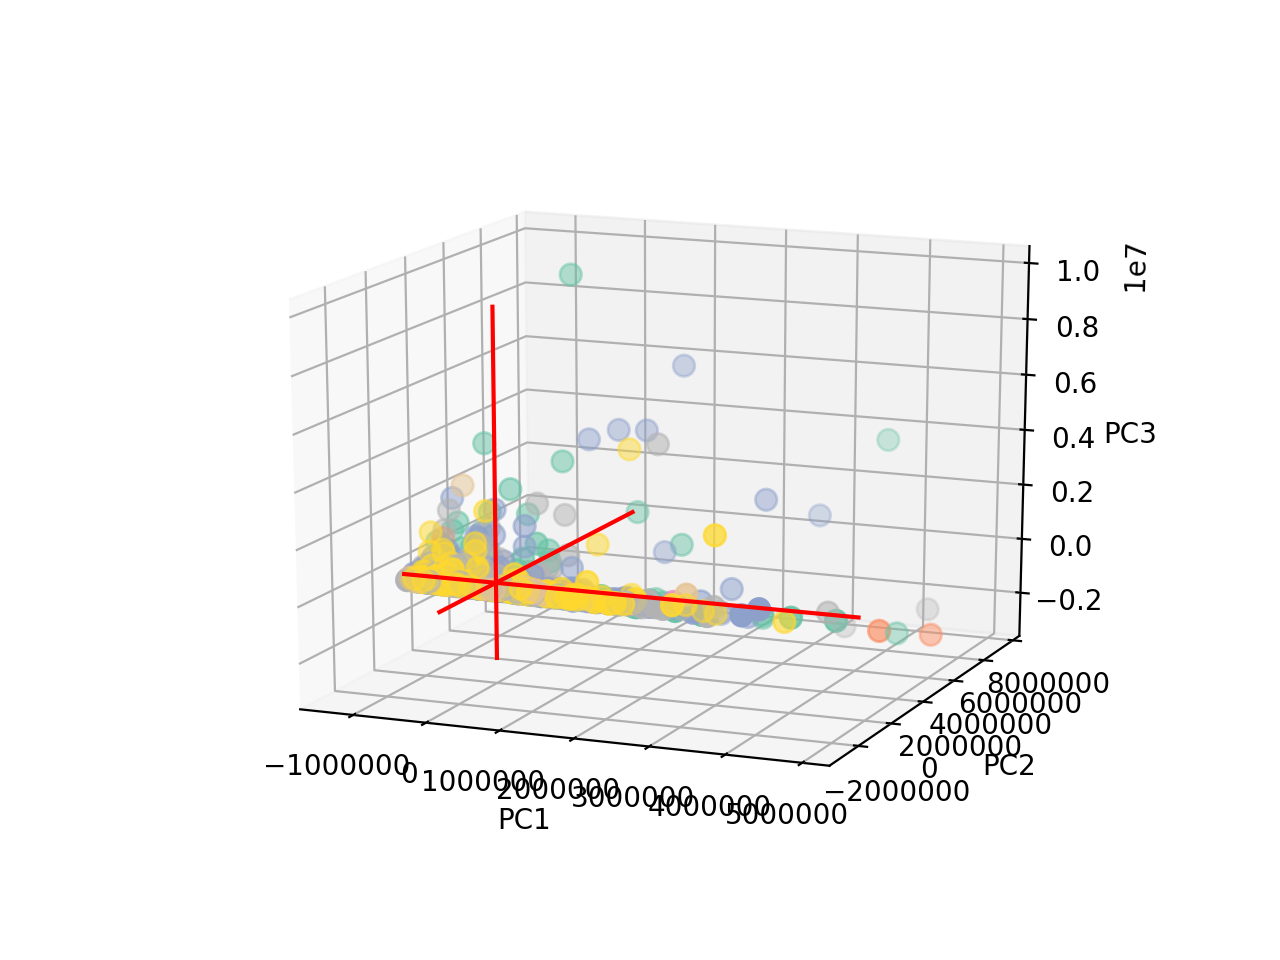

In [42]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

my_dpi=96
# plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
pca3 = PCA(n_components = 3).fit_transform(X_train)
df_pca3 = pd.DataFrame(data = pca3 , columns = ['PCA0', 'PCA1', 'PCA2'])

df_pca3['y'] = y_train
df_pca3['y']=pd.Categorical(df_pca3['y'])
my_color=df_pca3['y'].cat.codes
df_pca3 = df_pca3.drop('y', 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca3['PCA0'], df_pca3['PCA1'], df_pca3['PCA2'], c=my_color, cmap="Set2_r", s=60)

xAxisLine = ((min(df_pca3['PCA0']), max(df_pca3['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_pca3['PCA1']), max(df_pca3['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(df_pca3['PCA2']), max(df_pca3['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

Given the structure of the data, the kernel trick will probably not be useful as well. Nevertheless, we do a grid search to find the optimal kernel hyperparameters, and to see whether it will yield better results in higher dimensions. 

In [54]:
from sklearn.decomposition import KernelPCA

pipe_knn = make_pipeline(StandardScaler(),
                         SelectFromModel(RandomForestClassifier(n_estimators=50), threshold=0.001),
                         KernelPCA(),
                         KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'))

# sorted(pipe_knn.get_params().keys())

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'kernelpca__kernel': ['linear','poly','rbf','sigmoid','cosine'],
                               'kernelpca__n_components':[2,3,4,5,6],
                               'kernelpca__gamma':np.linspace(0.03, 0.05, 10)}],
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9274255156608098
{'kernelpca__gamma': 0.03222222222222222, 'kernelpca__kernel': 'cosine', 'kernelpca__n_components': 6}


As expected, kernel pca did not improve results. 

k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.89      0.89      0.89        19
  liver cancerous       0.97      0.93      0.95       127
      lung benign       0.79      0.85      0.81        13
   lung cancerous       0.90      0.97      0.94       146
   stomach benign       0.77      0.77      0.77        13
stomach cancerous       0.96      0.94      0.95       127
    uterus benign       0.67      1.00      0.80         4
 uterus cancerous       0.98      0.93      0.95       112

      avg / total       0.94      0.94      0.94       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


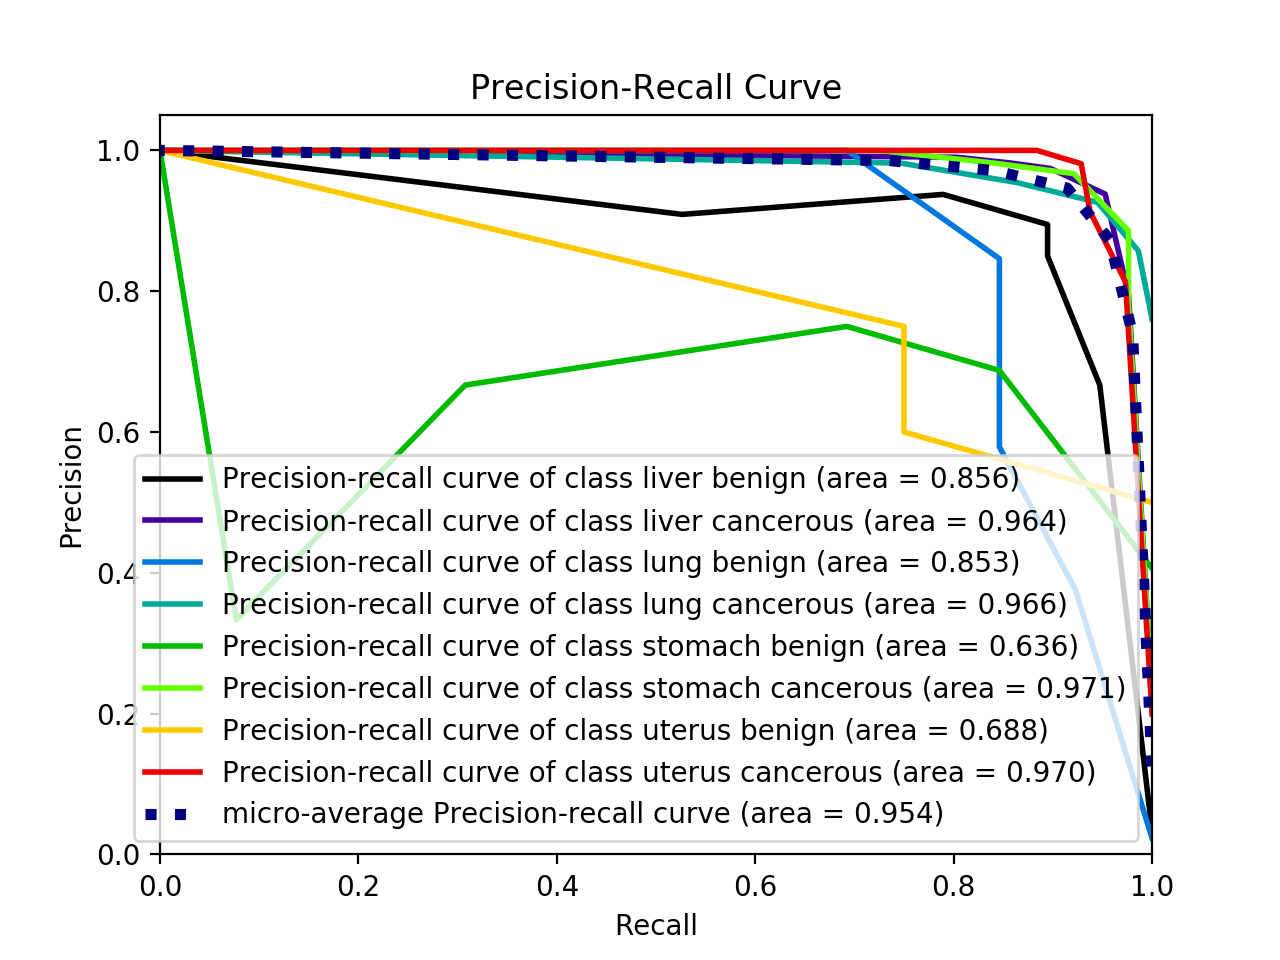

<IPython.core.display.Javascript object>


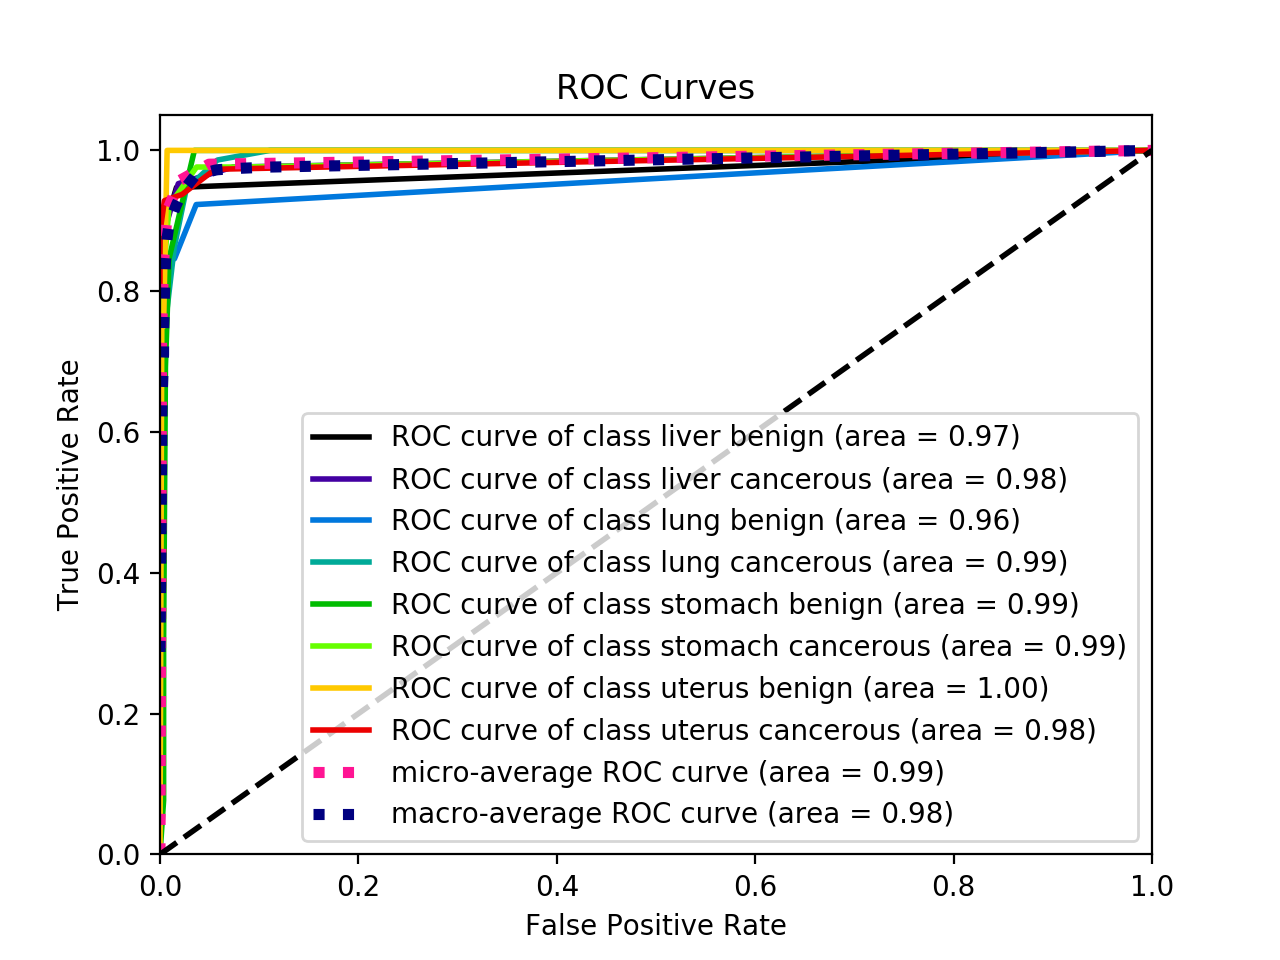

In [55]:
pipe_knn = make_pipeline(StandardScaler(),
                         SelectFromModel(RandomForestClassifier(n_estimators=50), threshold=0.001),
                         KernelPCA(kernel='cosine', n_components=6, gamma=0.0322),
                         KNeighborsClassifier(n_neighbors=5, p=1, metric='minkowski'))

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))
%matplotlib notebook
skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_knn, X=X_train, y=y_train, cv=5, n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.90943396 0.93939394 0.92748092 0.91570881 0.91439689]


Although we can get a comparably good result with the complex dimensionality reduction, the simple method of selecting features with random forests is preferred because of its simplicity.